<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Lilian/European_Call_nstock_auto_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
nstock = 10

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4984      0 --:--:-- --:--:-- --:--:--  4984
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 27 kB/s 
     |████████████████████████████████| 1.0 MB 45.3 MB/s 
+ set +ex
Installation succeeded!


### Deep Learning Barrier Option

We used Numba and CuPy in the previous notebook to run Monte Carlo simulation to determine the price of the Asian Barrier option. A Monte Carlo simulation needs millions of paths to get an accurate answer which is computationally intensive. [Ryan et al (2018)](https://arxiv.org/abs/1809.02233) showed that a deep learning model can be trained to value derivatives. The deep learning model is accurate and very fast, capable of producing valuations a million times faster than traditional models. In the this notebook, we will use a fully connected network to learn the pricing mode of the Asian Barrier option. Monte Carlo simulation is used as pricing ground truth for the training. We use the same Asian Barrier Option model as last notebook with parameters listed as following:

```
T - Maturity (yrs.)
S - Spot (usd)
K - Strike (usd)
sigma - Volatility (per.)
r - Risk Free Rate (per.)
mu - Stock Drift Rate (per.)
B - Barrier (usd)
```

### Batched Data generation

The dataset is an important part of the Deep learning training. We will modify the previous single Asian Barrier Option pricing code to handle a batch of Barrier Option pricing. 

In [ ]:
#@title
###Test: Judy's new X code
#N_STOCKS = 3

In [ ]:
#@title
#X = cupy.array([])
#for i in range(0,N_STOCKS):
  #X =  cupy.concatenate((X,cupy.array([1,1]), cupy.random.rand(3),cupy.array([1])))
#X = X.reshape(N_STOCKS,6)
#X

In [ ]:
#@title
#X = X * ((cupy.array([200.0, 0, 200.0, 0.4, 0.2, 0.2] * N_STOCKS, dtype = cupy.float32)).reshape(N_STOCKS, 6))
#X

### Train(Erin Version)

In [ ]:
# ################################# TEST ########################################
# %%writefile cupy_dataset.py

# import numba
# from numba import cuda
# import random
# import cupy
# import numpy as np
# import math
# import time
# import torch
# cupy.cuda.set_allocator(None)
# from torch.utils.dlpack import from_dlpack

# @cuda.jit
# def batch_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
#     # ii - overall thread index
#     ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#     stride = cuda.gridDim.x * cuda.blockDim.x
#     tmp3 = math.sqrt(T/N_STEPS)
#     for i in range(ii, N_PATHS * N_BATCH, stride):
#         batch_id = i // N_PATHS
#         path_id = i % N_PATHS
#         tmp1 = mu[batch_id]*T/N_STEPS
#         tmp2 = math.exp(-r[batch_id]*T)
#         running_average = 0.0
#         s_curr = S0[batch_id]
#         for n in range(N_STEPS):
#             s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price
#             running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
#             if i==0 and batch_id == 2:
#                 print(s_curr)
#             if running_average <= B[batch_id]: # if reach barrier, drop out the path
#                 break
#         payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
#         d_s[i] = tmp2 * payoff

# class NumbaOptionDataSet(object):
    
#     def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=3):  # 3 stocks
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 365
#         self.N_BATCH = batch
#         self.N_STOCKS = stocks
#         self.T = np.float32(1.0)
#         self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32) 
#         self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
#         self.number_of_threads = threads
#         cupy.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num > self.max_length:
#             raise StopIteration
        
#         Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
#         paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
#         for op in range(self.N_BATCH):
          
#           X = cupy.array([])
#           K_rand = cupy.random.rand(1)[0]
#           B_rand = cupy.random.rand(1)[0]
#           r_rand = cupy.random.rand(1)[0]
#           for i in range(0,self.N_STOCKS):
#             X =  cupy.concatenate((X,cupy.array([K_rand,B_rand]), cupy.random.rand(3),cupy.array([r_rand]))) #[K,B,S0,sigma,mu,r], K B r are shared
#           X = X.reshape(self.N_STOCKS,6)
#           X = X * ((cupy.array([200.0, 0.1, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
#           #X = cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)
#           #X = 0.9 + cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)*0.1
#           # scale the [0, 1) random numbers to the correct range for each of the option parameters
#           #X = (X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6)

#           # make sure the Barrier is smaller than the Strike price
#           # X[:, 1] = X[:, 0] * X[:, 1]
#           for i in range(self.N_STOCKS):
#             paras[op,i*6:(i+1)*6] = X[i,:]

#           stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
#           rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)

#           #stocks_randoms_cov = cupy.ones((self.N_STOCKS, self.N_STOCKS), dtype = cupy.float32)
#           #cupy.fill_diagonal(stocks_randoms_cov, rho)

#           #stocks_randoms_cov = (-0.99 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*2*0.99).reshape(self.N_STOCKS,self.N_STOCKS)
#           stocks_randoms_cov = cupy.array([1] * self.N_STOCKS*self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS,self.N_STOCKS)  #Covariance
#           cupy.fill_diagonal(stocks_randoms_cov, 1)

#           num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
#           randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
#                                                         num_of_randoms_each_stock, dtype=cupy.float32)
#           b1_r = randoms_gpu[:,0]
#           b2_r = randoms_gpu[:,1]
#           randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
#           interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
#           for i in range(interval):
#             if i % 2 == 0:
#                 ind = int(i/2)
#                 randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
#             else:
#                 ind = int(i//2)
#                 randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]

#           randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
#           batch_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
#                                 X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
#           o = self.output.reshape(self.N_STOCKS, self.N_PATHS)
#           Y[op] = o.mean(axis = 0).mean()

#         self.num += 1
#         return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))



# # ds = NumbaOptionDataSet(10, number_path=100000, batch=3, seed=random.randint(0,100), stocks=5)
# # for i in ds:
# #     print(i[0])
# ################################# TEST ########################################

### Train (European Call option)

In [ ]:
################################# TEST ########################################
%%writefile cupy_dataset.py

import numba
from numba import cuda
import random
import cupy
import numpy as np
import math
import time
import torch
cupy.cuda.set_allocator(None)
from torch.utils.dlpack import from_dlpack

@cuda.jit
def European_call_option(d_s, T, K, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    #tmp3 = math.sqrt(T/N_STEPS)
    for i in range(ii, N_PATHS * N_BATCH, stride):
        batch_id = i // N_PATHS
        path_id = i % N_PATHS
        h = T[batch_id] / N_STEPS
        tmp1 = r[batch_id]*T[batch_id]/N_STEPS 
        tmp2 = math.exp(-r[batch_id]*T[batch_id]) # discount
        tmp3 = math.sqrt(T[batch_id]/N_STEPS)
        #running_average = 0.0
        s_curr = S0[batch_id]
        for n in range(N_STEPS):
          s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price
          #s_curr = s_curr * math.exp((r[batch_id] - (1/2)*sigma[batch_id]**2)*h + sigma[batch_id] * tmp3 * d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH])
          #running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
          #if i==0 and batch_id == 2:
          #    print(s_curr)
          #if running_average <= B[batch_id]: # if reach barrier, drop out the path
          #    break
        #payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
        #payoff = s_curr - K[batch_id] if s_curr > K[batch_id] else 0
        #d_s[i] = tmp2 * payoff
        d_s[i] = s_curr

class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=3):  # 3 stocks
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        #self.N_STEPS = 365
        self.N_STEPS = 10000
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        #self.T = np.float32(1.0)
        self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32)
        self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
        self.number_of_threads = threads
        cupy.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num > self.max_length:
            raise StopIteration
        
        Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
        paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
        #paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 5), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          X = cupy.array([])
          #T_rand = cupy.random.rand(1)[0]
          K_rand = cupy.random.rand(1)
          #B_rand = cupy.random.rand(1)[0]
          r_rand = cupy.random.rand(1)
          for i in range(0, self.N_STOCKS):
            #X =  cupy.concatenate((X, cupy.array([K_rand,B_rand]), cupy.random.rand(3), cupy.array([r_rand]))) #[K,B,S0,sigma,mu,r], K B r are shared
            X = cupy.concatenate((X, cupy.array([1.0]), K_rand, cupy.random.rand(3), r_rand))
          
          X = X.reshape(self.N_STOCKS, 6)
          #X = X * ((cupy.array([200.0, 0.1, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
          #[T, K, S0, sigma, mu, r]
          X = X * ((cupy.array([1, 150.0, 150.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
          #X = cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)
          #X = 0.9 + cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)*0.1
          # scale the [0, 1) random numbers to the correct range for each of the option parameters
          #X = (X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6)

          # make sure the Barrier is smaller than the Strike price
          # X[:, 1] = X[:, 0] * X[:, 1]
          for i in range(self.N_STOCKS):
            paras[op,i*6:(i+1)*6] = X[i,:]
            #paras[op, i*5:(i+1)*5] = X[i,:]

          stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
          rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)

          #stocks_randoms_cov = cupy.ones((self.N_STOCKS, self.N_STOCKS), dtype = cupy.float32)
          #cupy.fill_diagonal(stocks_randoms_cov, rho)

          #stocks_randoms_cov = (-0.99 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*2*0.99).reshape(self.N_STOCKS,self.N_STOCKS)
          if self.N_STOCKS != 1:
            randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
            # stocks_randoms_cov = cupy.array([0] * self.N_STOCKS*self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS,self.N_STOCKS)  #Covariance
            # cupy.fill_diagonal(stocks_randoms_cov, 1)

            # num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
            # randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
            #                                               num_of_randoms_each_stock, dtype=cupy.float32)
            # b1_r = randoms_gpu[:,0]
            # b2_r = randoms_gpu[:,1]
            # randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
            # interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
            # for i in range(interval):
            #   if i % 2 == 0:
            #       ind = int(i/2)
            #       randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
            #   else:
            #       ind = int(i//2)
            #       randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]
          if self.N_STOCKS == 1:
            randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          
          European_call_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, X[:, 0], 
                                X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
          o = self.output.reshape(self.N_STOCKS, self.N_PATHS) # this contains prices for each stock for each path at time T
          K = K_rand * 150
          r = r_rand * 0.2
          o = o.mean(axis = 0) # average across stocks end prices
          payoff = np.maximum(o - K, 0) # compute payoff
          payoff = payoff * np.exp(-r*1) # T=1, discount
          Y[op] = payoff.mean()

        self.num += 1
        return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = NumbaOptionDataSet(1, number_path = 10000, batch = 3, seed = random.randint(0,100), stocks=nstock)
# for i in ds:
#     print(i)
################################# TEST ########################################

Writing cupy_dataset.py


### For verification (Monte Carlo for n-stocks basket)

In [ ]:
# def test(array):
#   S1 = array[2]
#   S2 = array[8]
#   S3 = array[14]
#   sigma1 = array[3]
#   sigma2 = array[9]
#   sigma3 = array[15]
#   T = 1  
#   K = array[1]
#   r = array[5]

#   dt = 1/1000
#   N = round(T/dt)
#   t = np.linspace(0, T, N)

#   out = []

#   for i in range(10000):
#     W1 = np.random.standard_normal(size = N)
#     W1 = np.cumsum(W1) * np.sqrt(dt)
#     W2 = np.random.standard_normal(size = N)
#     W2 = np.cumsum(W2) * np.sqrt(dt)
#     W3 = np.random.standard_normal(size = N)
#     W3 = np.cumsum(W3) * np.sqrt(dt)

#     # W = np.random.standard_normal(size = N)
#     # W = np.cumsum(W) * np.sqrt(dt)
    
#     P1_T = (S1 * np.exp((r - 0.5*sigma1**2) *t + sigma1 * W1))[-1]
#     P2_T = (S2 * np.exp((r - 0.5*sigma2**2) *t + sigma2 * W2))[-1]
#     P3_T = (S3 * np.exp((r - 0.5*sigma3**2) *t + sigma3 * W3))[-1]
#     payoff = (P1_T+P2_T+P3_T)/3 - K if (P1_T+P2_T+P3_T)/3 > K else 0
#     out.append(payoff * np.exp(-r*T))
  
#   return(np.array(out).mean())

# print(test(np.array([1.0000e+00, 5.8549e+00, 3.6871e+01, 2.6866e-01, 1.9026e-01, 1.8305e-01,
#          1.0000e+00, 5.8549e+00, 4.1110e+00, 2.3714e-01, 5.9547e-02, 1.8305e-01,
#          1.0000e+00, 5.8549e+00, 1.6189e+01, 7.3936e-02, 1.1713e-01, 1.8305e-01])))
# print(test(np.array([1.0000e+00, 1.1296e+02, 7.4318e+01, 2.0409e-01, 1.9133e-01, 5.3904e-02,
#          1.0000e+00, 1.1296e+02, 5.3453e+01, 4.8439e-02, 5.8557e-02, 5.3904e-02,
#          1.0000e+00, 1.1296e+02, 3.8721e+01, 2.0259e-01, 6.0423e-02, 5.3904e-02])))
# print(test(np.array([1.0000e+00, 3.2307e+01, 3.8874e+01, 2.5820e-01, 1.9522e-01, 8.6353e-02,
#          1.0000e+00, 3.2307e+01, 3.6077e+01, 3.7123e-01, 1.8810e-01, 8.6353e-02,
#          1.0000e+00, 3.2307e+01, 6.9274e+01, 2.4100e-01, 1.9839e-01, 8.6353e-02])))
# print(test(np.array([1.0000e+00, 2.4764e+01, 6.6956e+01, 2.0769e-01, 9.8127e-02, 1.7302e-01,
#          1.0000e+00, 2.4764e+01, 3.6483e+01, 8.9075e-02, 1.9375e-01, 1.7302e-01,
#          1.0000e+00, 2.4764e+01, 9.4748e+01, 2.6420e-01, 1.2015e-01, 1.7302e-01])))
# print(test(np.array([1.0000e+00, 8.4591e+01, 1.2730e+02, 2.8949e-02, 1.0954e-01, 1.3706e-01,
#          1.0000e+00, 8.4591e+01, 1.2859e+02, 1.5262e-01, 1.4064e-03, 1.3706e-01,
#          1.0000e+00, 8.4591e+01, 4.6679e+01, 2.6688e-01, 1.5895e-01, 1.3706e-01])))
# print(test(np.array([1.0000e+00, 6.8433e+01, 3.5593e+01, 6.5870e-02, 6.8068e-02, 1.3578e-02,
#          1.0000e+00, 6.8433e+01, 2.3864e+01, 9.5815e-02, 1.6075e-01, 1.3578e-02,
#          1.0000e+00, 6.8433e+01, 1.1863e+02, 3.0400e-01, 5.6958e-02, 1.3578e-02])))

In [ ]:
# array = np.array([1.0000e+00, 8.3754e+01, 1.2787e+02, 2.7420e-01, 1.2507e-01, 1.7700e-01,
#          1.0000e+00, 8.3754e+01, 4.0869e+01, 3.3302e-01, 1.7439e-01, 1.7700e-01,
#          1.0000e+00, 8.3754e+01, 1.1031e+02, 3.5945e-01, 1.5382e-01, 1.7700e-01])

# S1 = array[2]
# S2 = array[8]
# S3 = array[14]
# sigma1 = array[3]
# sigma2 = array[9]
# sigma3 = array[15]
# T = 1  
# K = array[1]
# r = array[5]

# dt = 1/100
# N = round(T/dt)
# t = np.linspace(0, T, N)

# out = []

# #for i in range(1000):
# W = np.random.standard_normal(size = N)
# W = np.cumsum(W) * np.sqrt(dt)
# P1_T = (S1 * np.exp((r - 0.5*sigma1**2) *t + sigma1 * W))
# P2_T = (S2 * np.exp((r - 0.5*sigma2**2) *t + sigma2 * W))[-1]
# P3_T = (S3 * np.exp((r - 0.5*sigma3**2) *t + sigma3 * W))[-1]
# #ayoff = (P1_T+P2_T+P3_T)/3 - K if (P1_T+P2_T+P3_T)/3 > K else 0
# #out.append(payoff * np.exp(-r*T))

# #return(np.array(out).mean())
# #P1_T
# import matplotlib.pyplot as plt
# plt.plot(t, P1_T)
# plt.show()

In [ ]:
# stocks_randoms_cov = cupy.array([0.99999] * 3 * 3, dtype = cupy.float32).reshape(3,3)  #Covariance
# cupy.fill_diagonal(stocks_randoms_cov, 1)

# stocks_randoms_mean = cupy.zeros(3, dtype = cupy.float32)

# num_of_randoms_each_stock = 2 * 3
# randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
#                                               num_of_randoms_each_stock, dtype=cupy.float32)
# randoms_gpu

### Model
To map the option parameters to price, we use 6 layers of fully connected neural network with hidden dimension 512 as inspired by [this paper](https://arxiv.org/abs/1809.02233). Writing this DL price model into a file `model.py`:-

### Modified Model

In [ ]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


class Net(nn.Module):

    def __init__(self, hidden=1024, nstock=3):
        super(Net, self).__init__()
        self.nstock = nstock
        self.fc1 = nn.Linear(6 * self.nstock, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        self.register_buffer('norm',
                             torch.tensor([1, 150.0, 150.0, 0.4, 0.2, 0.2] * self.nstock)) # don't use numpy here - will give error later

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


As we know the random parameters' scaling factors, the input parameters are first scaled back to a range of (0-1) by dividing them by (200.0, 198.0, 200.0, 0.4, 0.2, 0.2). Then they are projected 5 times to the hidden dimension of 512 after the `ELu` activation function. `ELu` is chosen because we need to compute the second order differentiation of the parameters. If use ReLu, the second order differentiation will always be zero. The last layer is a linear layer that maps the hidden dimension to the predicted option price. 

For training, we use [Ignite](https://github.com/pytorch/ignite) which is a high-level library to train neural networks in PyTorch. We use `MSELoss` as the loss function, `Adam` as the optimizer and `CosineAnnealingScheduler` as the learning rate scheduler. The following code is feeding the random option data to the pricing model to train it.

### Train

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 232 kB 8.9 MB/s 


In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net(nstock = nstock).cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len = 10000, number_path = 1024, batch = 4800)
# dataset = NumbaOptionDataSet(max_len = 100, number_path = 1024, batch = 32, stocks = 3)
dataset = NumbaOptionDataSet(max_len = 100, number_path = 1024, batch = 32, stocks = nstock)


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

loss 566.9605712890625 average time 0.0448838887000079 iter num 20
loss 570.4921875 average time 0.024491180649994247 iter num 40
loss 225.22239685058594 average time 0.01762218673331214 iter num 60
loss 154.68075561523438 average time 0.0142265866749824 iter num 80
loss 177.25177001953125 average time 0.012190218339990224 iter num 100
loss 40.71112060546875 average time 0.03830999365003436 iter num 20
loss 42.32828140258789 average time 0.021178385650011934 iter num 40
loss 33.418182373046875 average time 0.015458912050000133 iter num 60
loss 23.959014892578125 average time 0.012570231425007706 iter num 80
loss 6.072011470794678 average time 0.01084808232000114 iter num 100
loss 7.302041053771973 average time 0.03752139280002211 iter num 20
loss 1.3715113401412964 average time 0.020775652450015513 iter num 40
loss 1.5690009593963623 average time 0.01522968285001222 iter num 60
loss 1.7051074504852295 average time 0.01239892651251182 iter num 80
loss 3.108640193939209 average time 0.01

Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

$2365$ seconds The loss is keeping decreasing which means the pricing model can predict the option prices better. It takes about $12ms$ to compute one mini-batch in average, In the following sections, we will try to expore the full potentials of the GPU to accelerate the training.

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
model_save_name = f'EuCall_{str(nstock)}.pth'
path = F"/content/drive/MyDrive/AFP Project/Lilian/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
model_save_name = f'EuCall_{str(nstock)}.pth'
path = F"/content/drive/MyDrive/AFP Project/Lilian/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net(nstock = nstock).cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=60, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1, bias=True)
)


### Continue to train model

In [ ]:
 from ignite.engine import Engine, Events
 from ignite.handlers import Timer
 from torch.nn import MSELoss
 from torch.optim import Adam
 from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
 from ignite.handlers import ModelCheckpoint
 from model import Net
 from cupy_dataset import NumbaOptionDataSet
 timer = Timer(average=True)
 model = Net().cuda()
 loss_fn = MSELoss()
 optimizer = Adam(model.parameters(), lr=1e-3)
 dataset = NumbaOptionDataSet(max_len=10000, number_path = 1024, batch=4800)
 dataset = NumbaOptionDataSet(max_len=500, number_path = 1024, batch=32, stocks=nstock)

 def train_update(engine, batch):
     model.train()
     optimizer.zero_grad()
     x = batch[0]
     y = batch[1]
     y_pred = model(x)
     loss = loss_fn(y_pred[:,0], y)
     loss.backward()
     optimizer.step()
     return loss.item()

 trainer = Engine(train_update)
 log_interval = 20

 scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
 trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
 timer.attach(trainer,
              start=Events.EPOCH_STARTED,
              resume=Events.ITERATION_STARTED,
              pause=Events.ITERATION_COMPLETED,
              step=Events.ITERATION_COMPLETED)    
 @trainer.on(Events.ITERATION_COMPLETED)
 def log_training_loss(engine):
     iter = (engine.state.iteration - 1) % len(dataset) + 1
     if iter % log_interval == 0:
         print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
 trainer.run(dataset, max_epochs=20)

 model_save_name = 'checkpoint15.pth'
 path = F"/content/drive/MyDrive/AFP Project/Lilian/{model_save_name}" 
 torch.save(model.state_dict(), path)

### Inference and Greeks

We can load the model parameters and use it to do inference

In [ ]:
import torch

inputs = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05] * nstock]).cuda()
model(inputs.float())

tensor([[6.7574]], device='cuda:0', grad_fn=<AddmmBackward>)

One of the benefits of building a deep learning model is that the [Greeks](<https://en.wikipedia.org/wiki/Greeks_(finance)#First-order_Greeks>) can be easily computed. 
We just need to take advantage of the auto-grad feature in Pytorch. We can use `grad` function to compute the first order differentiation for parameters 'K, B, S0, sigma, mu, r'

In [ ]:
inputs = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05] * nstock]).cuda()
inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient

tensor([[ -0.5717,  -0.0932,   0.0814,   0.0559,  -0.6545,  18.3645,   0.2759,
          -0.0754,   0.0828,  -0.0519,  -0.7507,  14.1842,  -1.8373,  -0.0669,
           0.0820,   0.5587,  -0.0468,   9.2629,  -0.5405,  -0.0695,   0.0804,
           0.1436,  -1.0225,  -2.7266,  -0.5963,  -0.0833,   0.0817,   0.7110,
          -0.3268,  11.0988,   1.2659,  -0.0770,   0.0816,   1.2729,   0.2053,
          10.7046,  -1.0384,  -0.0664,   0.0820,   0.0839,   0.6279,  15.9660,
           0.7930,  -0.0840,   0.0820,   0.5934,  -0.6128,  -1.5332,  -2.7720,
          -0.0626,   0.0818,   0.5947,   0.6052,  11.0074,   0.5836,  -0.0818,
           0.0818,   0.4838,  -0.7380, -12.9466]], device='cuda:0')

Here we are going to plot the Delta graph:-

# Delta

#### Using gradient, Change only 1 S0 at a time

In [ ]:
#### Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S, ith):
    inputs = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

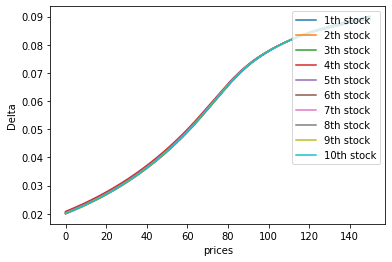

In [ ]:
for i in range(1, nstock+1):
  prices = np.arange(0, 150, 0.1)
  deltas = []
  for p in prices:
      deltas.append(compute_delta(p, i).item())
  fig = pylab.plot(prices, deltas, label = f'{i}th stock')
  pylab.legend(loc = 'upper right')
  pylab.xlabel('prices')
  pylab.ylabel('Delta')
  fig

#### Using Finite Difference, Change only 1 S0 at a time

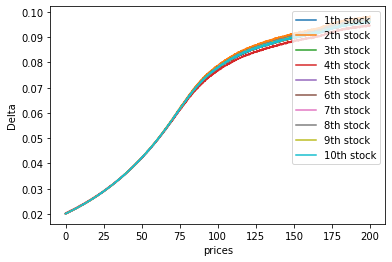

In [ ]:
## Using Finite Difference, Change only 1 S0 at a time
%matplotlib inline
import numpy as np
def compute_delta(S, ith):
    epsilon = 0.01
    inputs1 = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    inputs2 = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S + epsilon, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    delta = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return delta

for i in range(1, nstock+1):
  prices = np.arange(0, 200, 0.1)
  deltas = []
  for p in prices:
      deltas.append(compute_delta(p, i).item())
  fig = pylab.plot(prices, deltas, label = f'{i}th stock')
  pylab.legend(loc = 'upper right')
  pylab.xlabel('prices')
  pylab.ylabel('Delta')
  fig

#### Using Finite Difference, Change 3 S0 at a time

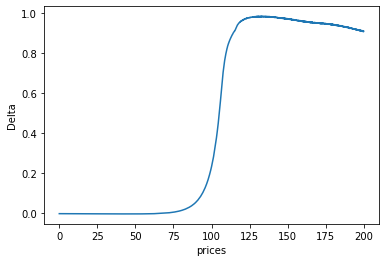

In [ ]:
##Using Finite Difference, Change 3 S0 at a time
%matplotlib inline
import numpy as np
def compute_delta(S):
    epsilon = 0.01
    inputs1 = torch.tensor([[1, 110.0, S, 0.35, 0.1, 0.05]*nstock]).cuda()
    inputs2 = torch.tensor([[1, 110.0, S + epsilon, 0.35, 0.1, 0.05]*nstock]).cuda()
    delta = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return delta


prices = np.arange(0, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

# Gamma

Calculating the second order derivative is easy in PyTorch too. We just need to apply the `grad` function twice. Use this mechanism, we can calculate the second order derivatives $\frac{\partial^2 P}{\partial K \partial S_0}$, $\frac{\partial^2 P}{\partial B \partial S_0}$, $\frac{\partial^2 P}{\partial S_0^2}$, $\frac{\partial^2 P}{\partial \sigma \partial S_0}$, $\frac{\partial^2 P}{\partial \mu \partial S_0}$, $\frac{\partial^2 P}{\partial r \partial S_0}$ in the following example.

In [ ]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn

inputs = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*nstock]).cuda()
inputs.requires_grad = True
x = model(inputs)

# instead of using loss.backward(), use torch.autograd.grad() to compute gradients
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
loss_grads = grad(x, inputs, create_graph=True)
drv = grad(loss_grads[0][0][2], inputs)
drv

(tensor([[-0.0030, -0.0004,  0.0003, -0.0026, -0.0050,  0.0771,  0.0002, -0.0003,
           0.0003, -0.0031, -0.0021,  0.0597, -0.0086, -0.0003,  0.0003, -0.0020,
           0.0010,  0.0390, -0.0041, -0.0003,  0.0003, -0.0036, -0.0078, -0.0084,
          -0.0046, -0.0003,  0.0003, -0.0002,  0.0035,  0.0468,  0.0036, -0.0003,
           0.0003,  0.0022,  0.0003,  0.0447, -0.0067, -0.0003,  0.0003, -0.0037,
           0.0027,  0.0700,  0.0021, -0.0003,  0.0003, -0.0008, -0.0011, -0.0080,
          -0.0125, -0.0003,  0.0003, -0.0015,  0.0026,  0.0382,  0.0012, -0.0003,
           0.0003, -0.0007, -0.0013, -0.0546]], device='cuda:0'),)

Gamma is the second order differenation of `S`. We can plot the the Gamma curve as a function of the stock price

#### Using gradient, Change only 1 S0 at a time

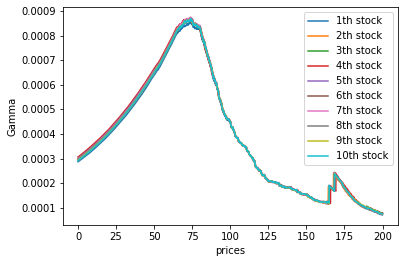

In [ ]:
##Using gradient, Change only 1 S0 at a time
import pylab
import numpy as np
def compute_gamma(S, ith):
  inputs = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
  # inputs = torch.tensor([[1, 110.0, S, 0.35, 0.1, 0.05] + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
  inputs.requires_grad = True
  x = model(inputs.float())
  #x = model(inputs)
  loss_grads = grad(x, inputs, create_graph=True)
  drv = grad(loss_grads[0][0][2], inputs)
  return drv[0][0][2]

for i in range(1, nstock+1):
  prices = np.arange(0, 200, 0.1)
  gammas = []
  for p in prices:
      gammas.append(compute_gamma(p, i).item())
  fig2 = pylab.plot(prices, gammas, label = f'{i}th stock')
  pylab.legend(loc = 'upper right')
  pylab.xlabel('prices')
  pylab.ylabel('Gamma')
  fig2

#### Using Finite Difference, Change only 1 S0 at a time

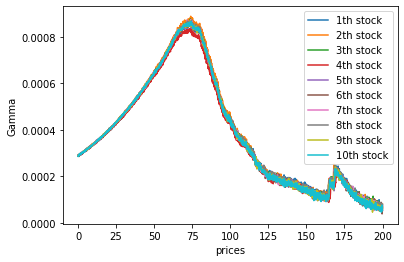

In [ ]:
##Using Finite Difference, Change only 1 S0 at a time
%matplotlib inline
import numpy as np
def compute_gamma(S, ith):
    epsilon = 0.5
    inputs1 = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    inputs2 = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S+epsilon, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    inputs3 = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S-epsilon, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    # inputs1 = torch.tensor([[1, 110.0, S, 0.35, 0.1, 0.05]  + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    # inputs2 = torch.tensor([[1, 110.0, S + epsilon, 0.35, 0.1, 0.05]  + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    # inputs3 = torch.tensor([[1, 110.0, S - epsilon, 0.35, 0.1, 0.05]  + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    gamma = (model(inputs2.float()) - 2*model(inputs1.float()) + model(inputs3.float()))/(epsilon**2)
    return gamma

for i in range(1, nstock+1):
  prices = np.arange(0, 200, 0.1)
  gammas = []
  for p in prices:
      gammas.append(compute_gamma(p, i).item())
  fig = pylab.plot(prices, gammas, label = f'{i}th stock')
  pylab.legend(loc = 'upper right')
  pylab.xlabel('prices')
  pylab.ylabel('Gamma')
  fig

#### Using Finite Difference, Change 3 S0 at a time

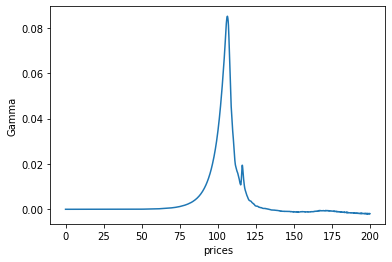

In [ ]:
##Using Finite Difference, Change 3 S0 at a time
%matplotlib inline
import numpy as np
def compute_gamma(S):
    epsilon = 0.5
    inputs1 = torch.tensor([[1, 110.0, S, 0.35, 0.1, 0.05]*nstock]).cuda()
    inputs2 = torch.tensor([[1, 110.0, S + epsilon, 0.35, 0.1, 0.05]*nstock]).cuda()
    inputs3 = torch.tensor([[1, 110.0, S - epsilon, 0.35, 0.1, 0.05]*nstock]).cuda()
    gamma = (model(inputs2.float()) - 2*model(inputs1.float()) + model(inputs3.float()))/(epsilon**2)
    return gamma

prices = np.arange(0, 200, 0.1)
gammas = []
for p in prices:
    gammas.append(compute_gamma(p).item())
fig = pylab.plot(prices, gammas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig

# Vega

#### Using finite difference, Change only 1 S0 at a time

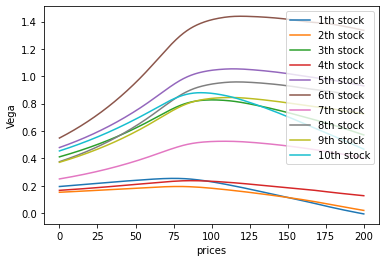

In [ ]:
##Using finite difference, Change only 1 S0 at a time
# vega
%matplotlib inline
import numpy as np
def compute_vega(S, ith):
    epsilon = 0.5

    inputs1 = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    inputs2 = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35+epsilon, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()

    vega = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return vega

for i in range(1, nstock+1):
  prices = np.arange(0, 200, 0.1)
  vegas = []
  for p in prices:
      vegas.append(compute_vega(p, i).item())
  fig = pylab.plot(prices, vegas, label = f'{i}th stock')
  pylab.legend(loc = 'upper right')
  pylab.xlabel('prices')
  pylab.ylabel('Vega')
  fig

#### Using Finite Difference, Change 3 S0 at a time

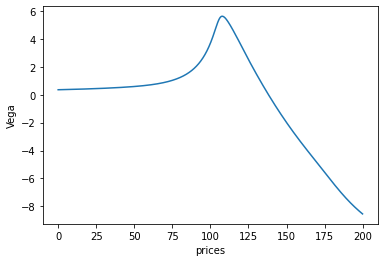

In [ ]:
##Using Finite Difference, Change 3 S0 at a time
# vega
%matplotlib inline
import numpy as np
def compute_vega(S):
    epsilon = 0.5
    inputs1 = torch.tensor([[1, 110.0, S, 0.35, 0.1, 0.05]*nstock]).cuda()
    inputs2 = torch.tensor([[1, 110.0, S, 0.35 + epsilon, 0.1, 0.05]*nstock]).cuda()
    vega = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return vega


prices = np.arange(0, 200, 0.1)
vegas = []
for p in prices:
    vegas.append(compute_vega(p).item())
fig = pylab.plot(prices, vegas)
pylab.xlabel('prices')
pylab.ylabel('Vega')
fig

[Implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the forecasted volatility of the underlying asset based on the quoted prices of the option. It is the reverse mapping of price to the option parameter given the model which is hard to do with the Monte Carlo simulation approach. But if we have the deep learning pricing model, it is an easy task. We can first plot the relationship between volatility and the option price

In [ ]:
# import pylab
# import numpy as np
# def compute_price(sigma):
#     inputs = torch.tensor([[1, 110.0, 110.0, sigma, 0.1, 0.05]]).cuda()
#     x = model(inputs.float())
#     #x = model(inputs)
#     return x.item()
# sigmas = np.arange(0, 0.5, 0.1)
# prices = []
# for s in sigmas:
#     prices.append(compute_price(s))
# fig3 = pylab.plot(sigmas, prices)
# pylab.xlabel('Sigma')
# pylab.ylabel('Price')
# fig3

Given the prices `P`, the implied volatility is the root of the function `compute_price`. We can use bisection to find the root.

In [ ]:
# def bisection_root(small, large, fun, target, EPS=1e-6):
#     if fun(large) - target < 0:
#         print('upper bound is too small')
#         return None
#     if fun(small) - target > 0:
#         print('lower bound is too large')
#         return None
#     while large - small > EPS:
#         mid = (large + small) / 2.0
#         if fun(mid) - target >= 0:
#             large = mid
#         else:
#             small = mid
#     mid = (large + small) / 2.0
#     return mid, abs(fun(mid) - target)
# quoted_price = 16.0
# sigma, err = bisection_root(0, 0.5, compute_price, quoted_price)
# print('implied volativity', sigma, 'error', err)     